Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Prepare)

Today's guided module project will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass you raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a a pipeline without worry about other data preprocessing steps. 

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) is transforming our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time. Train your vectorizer separately (ie out of the grid-searched pipeline). 

In [1]:
# Import Statements
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

In [3]:
train.description = train.description.str.strip()
train

,id,description,ratingCategory
0,1321,"Sometimes, when whisky is batched, a few lefto...",1
1,3861,An uncommon exclusive bottling of a 6 year old...,0
2,655,This release is a port version of Amrut’s Inte...,1
3,555,This 41 year old single cask was aged in a she...,1
4,1965,"Quite herbal on the nose, with aromas of dried...",1
...,...,...,...
4082,3342,What lies beneath the surface of Dewar’s? Here...,1
4083,3130,After 6 to 7 years of maturation in bourbon ca...,1
4084,2811,"Bright, delicate, and approachable. While not ...",1
4085,478,I’m calling this the pitmaster’s dram: the nos...,1


In [4]:
train.ratingCategory.value_counts()

1    2881
0    1141
2      65
Name: ratingCategory, dtype: int64

In [5]:
test.description = test.description.str.strip()
test

,id,description
0,3461,Style: Speyside single malt scotch Color: Waln...
1,2604,"Very bright and lively, with a nice balance of..."
2,3341,A new oloroso-forward Chivas positioned to spl...
3,3764,Aged in bourbon casks and then enhanced in Rio...
4,2306,"There is a freshness to the wood on the nose, ..."
...,...,...
1017,2853,"Care for a small batch, bourbon-matured blend ..."
1018,219,"This is the pick of the bunch, the whisky equi..."
1019,1286,"Port Ellen, for sure! Very old-fashioned in na..."
1020,2201,"Youthful and very lively. Bold, crisp, spices ..."


In [20]:
sample

,id,ratingCategory
0,3461,2
1,2604,2
2,3341,2
3,3764,2
4,2306,2
...,...,...
1017,2853,2
1018,219,2
1019,1286,2
1020,2201,2


In [21]:
# Create Pipeline Components

vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
rfc = RandomForestClassifier()

In [22]:
# Define the Pipeline
pipe = Pipeline([
                 #Vectorizer
                 ('vect', vect),
                 # Classifier
                 ('clf', rfc)
                ])

# The pipeline puts together a bunch fit then transform,fit then predict. 

In [6]:
parameters = {
    'vect__max_df': ( 0.75, 1.0),
    'vect__min_df': (.02, .05),
    'vect__max_features': (500,1000),
    'clf__n_estimators':(5, 10),
    'clf__max_depth':(15,20)
}

In [23]:
grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=-2, verbose=1)

In [ ]:
grid_search.fit(train.description, train.ratingCategory)

In [25]:
grid_search.best_score_

0.7230220886839263

In [31]:
submission = test.copy()
submission["ratingCategory"] = pd.Series(grid_search.predict(test.description))
submission = submission[["id", "ratingCategory"]]
submission

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1
...,...,...
1017,2853,1
1018,219,1
1019,1286,1
1020,2201,1


In [33]:
submission.to_csv('data/submission_01_08_04_2020.csv', index=None)

In [7]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [12]:
STOP_WORDS = nlp.Defaults.stop_words.union({'-pron-', '.', ',', '(', ')', '-', "’", 'whisky', 'whiskey'})

lemmas = pd.Series([[token.lemma_.lower() for token in doc if token.lemma_.lower() not in STOP_WORDS] for doc in nlp.pipe(train['description'], batch_size=500)])
train['lemmas'] = lemmas

In [14]:
train.lemmatizedDescription = train.lemmas.apply(lambda x : " ".join(x))

In [15]:
# Object from Base Python
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [16]:
wc = count(train['lemmas'])

In [17]:
import squarify
import matplotlib.pyplot as plt

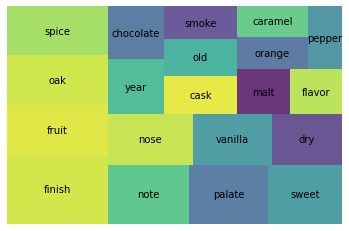

In [26]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.show()

In [25]:
grid_search.fit(train.lemmatizedDescription, train.ratingCategory)
grid_search.best_score_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-2)]: Done 160 out of 160 | elapsed:   39.3s finished


0.7259635556167384

In [30]:
grid_search.predict(["bad sour gross terrible worst thing I've ever had 100% would never eat again"])

array([1], dtype=int64)

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

## Challenge

You're trying to achieve 75% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Overview

In [31]:
# Import
from sklearn.decomposition import TruncatedSVD

vect = TfidfVectorizer(stop_words='english')

svd = TruncatedSVD(n_components=100, # Just here for demo. 
                   algorithm='randomized',
                   n_iter=10)

In [32]:
params = { 
    'lsi__svd__n_components': [10,100,250],
    'lsi__vect__max_df':[.9, .95, 1.0],
    'lsi__vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators':[5,10,20]
}

In [33]:
# LSI
lsi = Pipeline([('vect', vect), ('svd', svd)])


# Pipe
pipe = Pipeline([('lsi', lsi), ('clf', rfc)])

In [34]:
print(pipe)

Pipeline(memory=None,
         steps=[('lsi',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  TfidfVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=None, min_df=1,
                                                  ngram_range=(1, 1), norm='l2',
                                                  preprocessor=None,
                                                  smooth_idf=True,
                                                  stop_words='english',
                                                  strip_a

In [37]:
grid_search = GridSearchCV(pipe,params, cv=5, n_jobs=-2, verbose=3)

In [38]:
grid_search.fit(train.lemmatizedDescription, train.ratingCategory)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-2)]: Done 405 out of 405 | elapsed: 70.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lsi',
                                        Pipeline(memory=None,
                                                 steps=[('vect',
                                                         TfidfVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='strict',
                                                                         dtype=<class 'numpy.float64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                                                                         lowercase=True,
                                                                         max_df=1.0,
             

In [39]:
grid_search.best_score_

0.7247359742393453

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

# Overview

In [ ]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [ ]:
doc = nlp("Two bananas in pyjamas")

In [ ]:
bananas_vector = doc.vector
print(len(bananas_vector))

In [ ]:
def get_word_vectors(docs):
    return [nlp(doc).vector for doc in docs]

In [ ]:
X = get_word_vectors(train['description'])

len(X) == len(data.data)

In [ ]:
X_test = get_word_vectors(test['description'])

In [ ]:
rfc.fit(X, train['ratingCategory'])

In [ ]:
rfc.score(X, train['ratingCategory'])

In [ ]:
rfc.predict(X_test)

In [ ]:
test['ratingCategory'] = rfc.predict(X_test)

In [ ]:
test[['id', 'ratingCategory']].to_csv('testSolutionSubmission.csv', header=True, index=False)

## Follow Along

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Review

To review this module: 
* Continue working on the Kaggle competition
* Find another text classification task to work on